<a href="https://colab.research.google.com/github/AndreiAf02/STAT561_Project/blob/main/STAT561_Project_Code_V6_Heart_Disease_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STAT 561 Project - Predicting Heart Disease From Diabetes with Transfer Learning

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [406]:
pip install ucimlrepo

In [407]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [408]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [409]:
X.iloc[:,6]

,HeartDiseaseorAttack
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,0
253677,0
253678,0


In [410]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [411]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [412]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


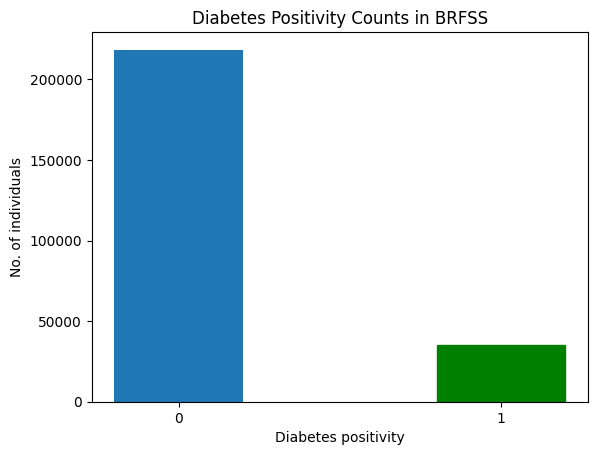

In [413]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

For the Heart Disease prediction, we split the dataset between low education level (**now including high-school dropouts**) and the high education level. The high-education data (with diabetes as response variable/label) becomes the source data and the low-education data (with Heart Disease as response variable/label) is the target data.

In [414]:
data_S = data2[data2[19] >= 0.5]  ## Source domain and classification
data_S_X = data_S.drop(data_S.columns[[6, 21]], axis=1)
data_S_y = data_S.iloc[:, 21]    ## Response variable of interest is Diabetes

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2[data2[19] < 0.5]

data_T_X = data_T.drop(data_T.columns[[6, 21]], axis=1)
data_T_y = data_T.iloc[:, 6]    ## Response variable of interest in Heart Disease

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [415]:
data_T_full

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,6
3,1.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0.0
21,1.0,1.0,1.0,0.302326,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,1.000000,0.2,0.285714,0.0
27,1.0,1.0,1.0,0.186047,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.916667,0.2,0.428571,1.0
31,1.0,0.0,1.0,0.244186,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,1.0,1.0,1.000000,0.4,0.285714,0.0
34,1.0,1.0,1.0,0.139535,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.916667,0.4,0.285714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253668,0.0,1.0,1.0,0.197674,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.25,0.0,0.000000,1.0,1.0,0.750000,0.4,0.714286,1.0
253669,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.00,0.0,0.100000,0.0,1.0,0.416667,0.2,0.428571,0.0
253671,1.0,1.0,1.0,0.127907,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.75,0.0,0.166667,0.0,1.0,0.583333,0.4,0.142857,1.0
253672,1.0,0.0,1.0,0.209302,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,0.2,0.000000,1.0


## Source domain and task labels:

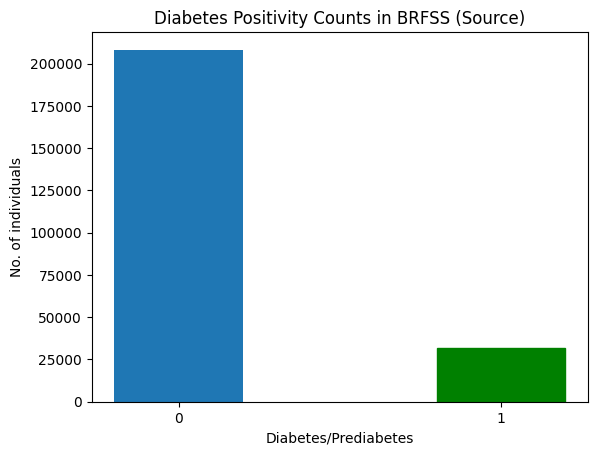

In [416]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes/Prediabetes")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Source)")
plt.show()

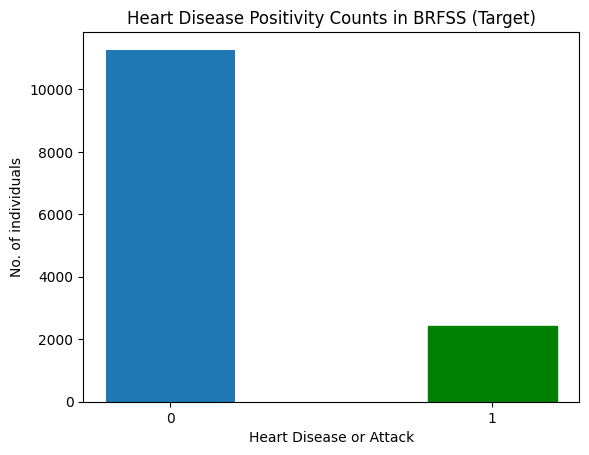

In [417]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Heart Disease or Attack")
plt.ylabel("No. of individuals")
plt.title("Heart Disease Positivity Counts in BRFSS (Target)")
plt.show()

## Updated Code (Modified from Shreya's code):

In [418]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model

# def create_dnn_model(input_shape):
#   model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
#     ])

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

#   return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [419]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return model


In [420]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")

In [421]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [422]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :20]
    y_SRS = data_SRS_RUS.iloc[:, 20]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :20]
    y_SRS = data_SRS_RUS.iloc[:, 20]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :20]
    y_Sy = data_Sy_RUS.iloc[:, 20]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :20]
    y_Sy = data_Sy_RUS.iloc[:, 20]

    return X_Sy, y_Sy

## Oversampling functions:

In [423]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :20]
    y_SRS = data_SRS_ROS.iloc[:, 20]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :20]
    y_Sy = data_Sy_ROS.iloc[:, 20]

    return X_Sy, y_Sy

# k = 48

# Nsamples = k*(oversample_size-undersample_size)/undersample_size
# # print(Nsamples)

# np.random.seed(123)
# start = np.random.choice(int(k), int(Nsamples), replace=True)
# # print(start)


# Row = []

# for j in range(len(start)):
#   for i in range(int(undersample_size/k)):
#     row = start[j]+int(k*i)-1
#     Row.append(row)

In [424]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

In [425]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (191988, 20)
y_S_train: (191988,)
X_S_test: (47997, 20)
y_S_test: (47997,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_640 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_641 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_642 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_643 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_644 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_645 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_646 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - AUC: 0.6205 - loss: 0.4750 - val_AUC: 0.7422 - val_loss: 0.4293
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.7591 - loss: 0.4021 - val_AUC: 0.7664 - val_loss: 0.4113
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7829 - loss: 0.3906 - val_AUC: 0.7650 - val_loss: 0.4100
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7915 - loss: 0.3818 - val_AUC: 0.7676 - val_loss: 0.4167
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7881 - loss: 0.3846 - val_AUC: 0.7672 - val_loss: 0.4122
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7868 - loss: 0.3894 - val_AUC: 0.7627 - val_loss: 0.4176
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7900 - loss: 0.3835 - val_AUC: 0.7679 - val_loss: 0.4143
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7974 - loss: 0.3870 - val_AUC: 0.7671 - val_loss: 0.4100
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

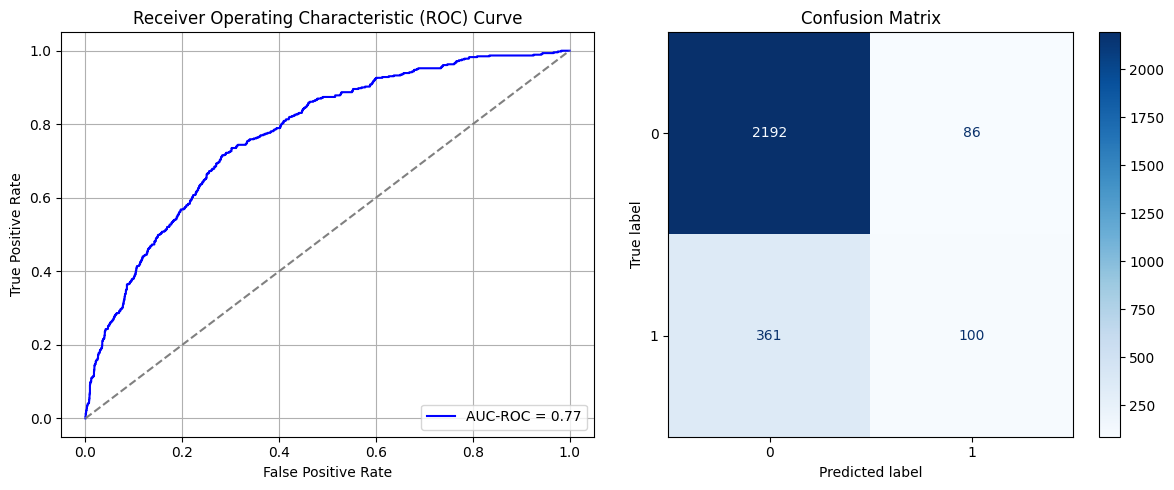

Best threshold based on F1-score: 0.23644056916236877
Time elapsed (performance): 33.48686292600178


<Sequential name=sequential_102, built=True>

In [426]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [427]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_647 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_648 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_649 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_650 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_651 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_652 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_653 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.7787 - loss: 0.3311 - val_AUC: 0.8211 - val_loss: 0.3141
Epoch 2/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8193 - loss: 0.3075 - val_AUC: 0.8240 - val_loss: 0.3168
Epoch 3/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8226 - loss: 0.3071 - val_AUC: 0.8237 - val_loss: 0.3187
Epoch 4/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8265 - loss: 0.3021 - val_AUC: 0.8258 - val_loss: 0.3111
Epoch 5/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8254 - loss: 0.3055 - val_AUC: 0.8257 - val_loss: 0.3105
Epoch 6/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8255 - loss: 0.3024 - val_AUC: 0.8257 - val_loss: 0.3112
Epoch 7/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8267 - loss: 0.3036 - val_AUC: 0.8252 - val_loss: 0.3186
Epoch 8/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8274 - loss: 0.3050 - val_AUC: 0.8269 - val_loss: 0.3106
Epoch 9/10
4800/4800 ━━━━━━━━━━━

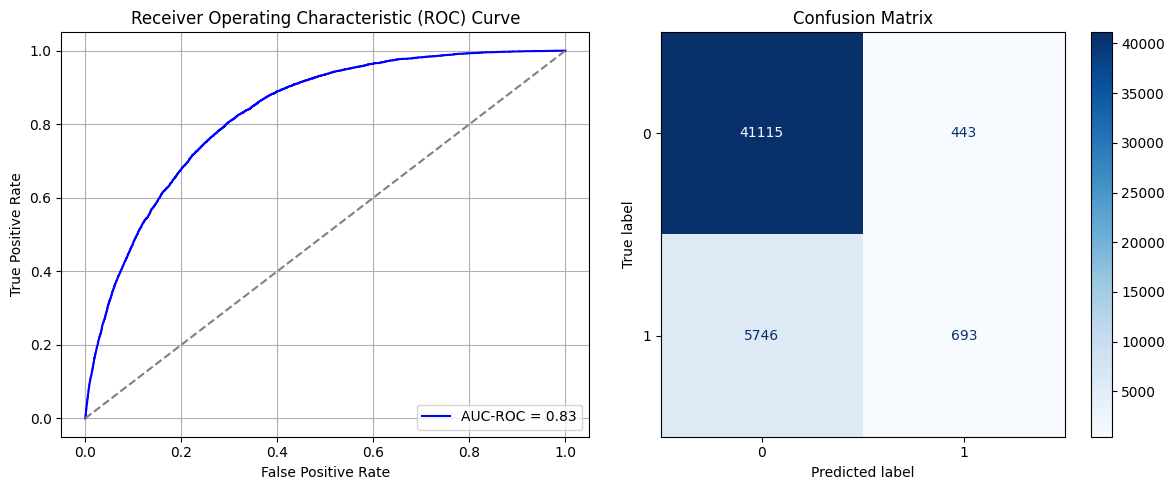

Best threshold based on F1-score: 0.20668137073516846
Time elapsed (performance): 180.39735284199924


<Sequential name=sequential_103, built=True>

In [428]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

In [429]:
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7113082031465741
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89      2278
         1.0       0.37      0.15      0.21       461

    accuracy                           0.81      2739
   macro avg       0.61      0.55      0.55      2739
weighted avg       0.77      0.81      0.78      2739

FPR 0.050921861281826165 TPR: 0.14750542299349245 FNR: 0.8524945770065075 TNR: 0.9490781387181738


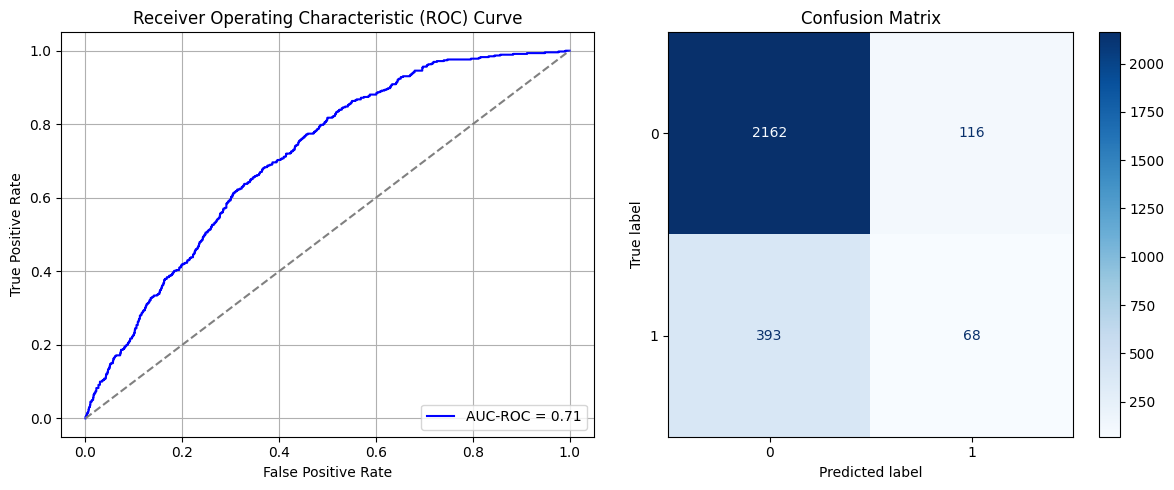

Best threshold based on F1-score: 0.272134929895401
False Negative Rate: 0.8524945770065075
Time elapsed (performance): 0.7998020089980855


In [430]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_654 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_655 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_656 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_657 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_658 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_659 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_660 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.7075 - loss: 0.4338 - val_AUC: 0.6927 - val_loss: 0.4457
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7154 - loss: 0.4200 - val_AUC: 0.6927 - val_loss: 0.4428
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7209 - loss: 0.4216 - val_AUC: 0.6928 - val_loss: 0.4422
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7188 - loss: 0.4091 - val_AUC: 0.6930 - val_loss: 0.4414
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7115 - loss: 0.4194 - val_AUC: 0.6931 - val_loss: 0.4417
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7087 - loss: 0.4303 - val_AUC: 0.6934 - val_loss: 0.4431
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7199 - loss: 0.4190 - val_AUC: 0.6929 - val_loss: 0.4420
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7178 - loss: 0.4153 - val_AUC: 0.6933 - val_loss: 0.4418
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7242 

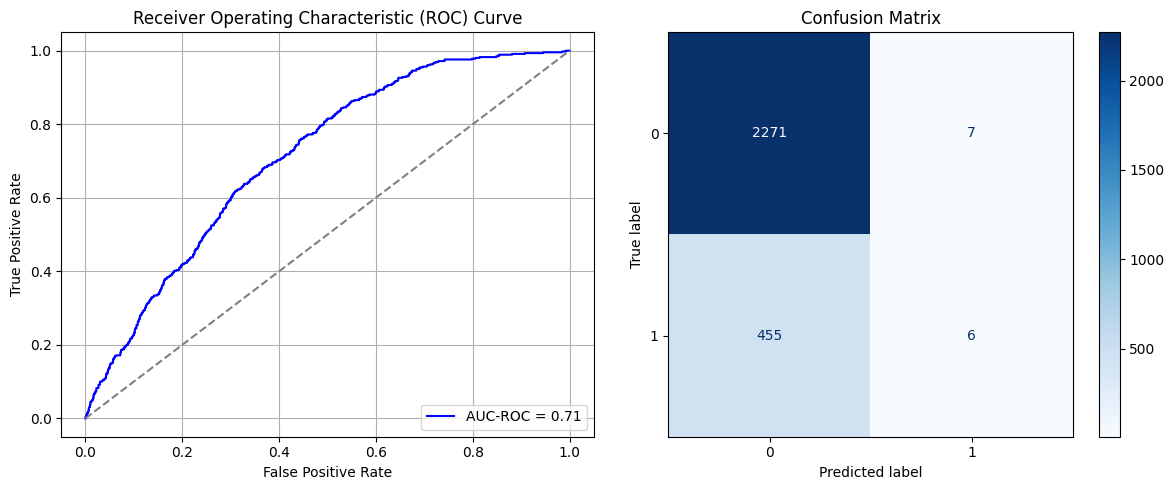

Best threshold based on F1-score: 0.23249509930610657
Time elapsed (performance): 22.09477391299879


In [431]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [299]:
data_S_full
data_S_majority = data_S_full[data_S_full['Diabetes_binary'].isin([0])]
data_S_minority = data_S_full[data_S_full['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

31820
208165


In [300]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRS)

31820
208165
74675     0
74495     0
183000    0
172231    0
47797     0
         ..
253630    1
253636    1
253659    1
253670    1
253679    1
Name: Diabetes_binary, Length: 63640, dtype: int64


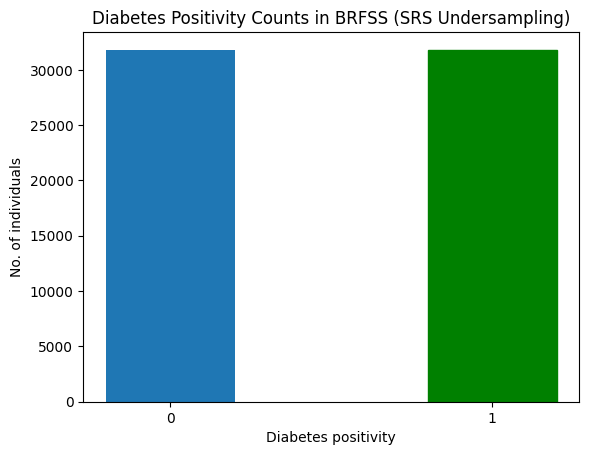

In [283]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [304]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train[6])
print(y_T_train_SRS)


1964
8992
171682    0.0
212930    0.0
176967    0.0
68316     0.0
253412    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3928, dtype: float64


In [305]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [306]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_423 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_424 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_425 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_426 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_427 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_428 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_429 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.7789 - loss: 0.5606 - val_AUC: 0.8151 - val_loss: 0.5213
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8121 - loss: 0.5220 - val_AUC: 0.8175 - val_loss: 0.5279
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8175 - loss: 0.5175 - val_AUC: 0.8182 - val_loss: 0.5195
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8236 - loss: 0.5105 - val_AUC: 0.8183 - val_loss: 0.5184
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8241 - loss: 0.5097 - val_AUC: 0.8194 - val_loss: 0.5205
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8245 - loss: 0.5089 - val_AUC: 0.8206 - val_loss: 0.5215
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8270 - loss: 0.5058 - val_AUC: 0.8210 - val_loss: 0.5188
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8293 - loss: 0.5040 - val_AUC: 0.8215 - val_loss: 0.5165
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━

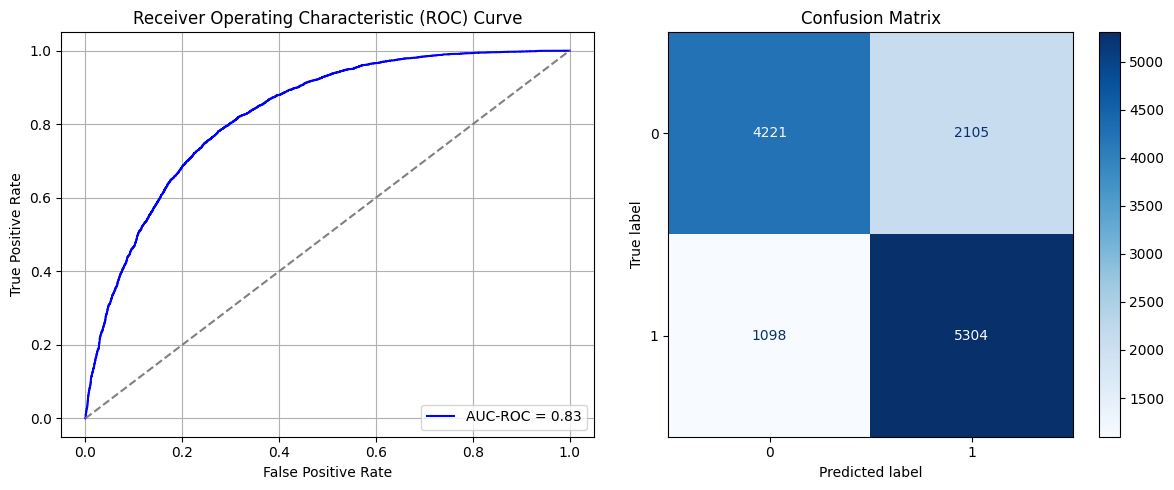

<ipython-input-250-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9639389514923096
Time elapsed (performance): 55.07461575599882


<Sequential name=sequential_71, built=True>

In [307]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7191317877881233
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.37      0.54      2278
         1.0       0.23      0.93      0.37       461

    accuracy                           0.47      2739
   macro avg       0.60      0.65      0.45      2739
weighted avg       0.84      0.47      0.51      2739

FPR 0.6268656716417911 TPR: 0.9327548806941431 FNR: 0.06724511930585683 TNR: 0.3731343283582089


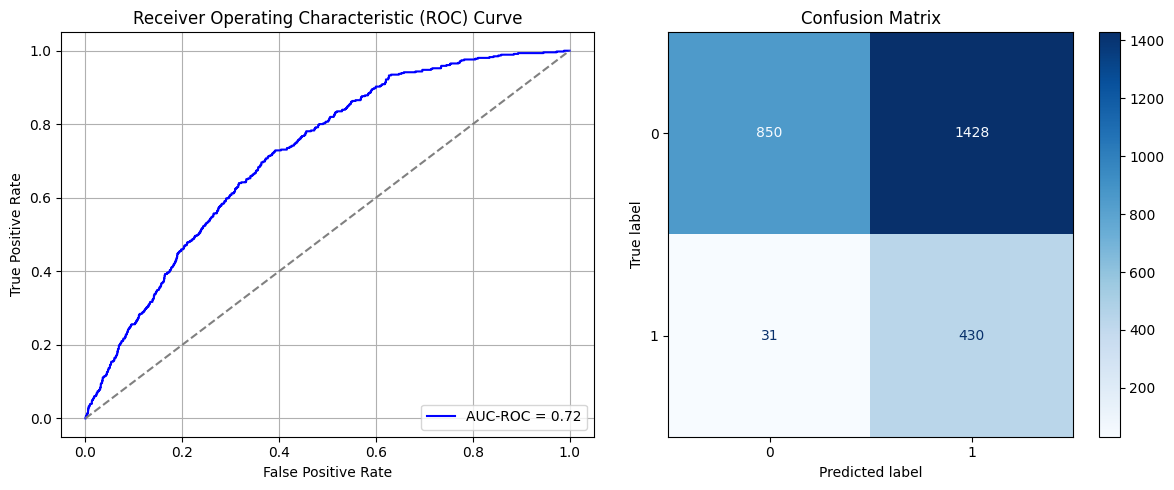

Best threshold based on F1-score: 0.7470478415489197
False Negative Rate: 0.06724511930585683
Time elapsed (performance): 0.7392464980002842


In [308]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_430 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_431 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_432 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_433 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_434 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_435 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_436 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6527 - loss: 0.6736 - val_AUC: 0.5766 - val_loss: 0.4663
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6712 - loss: 0.4493 - val_AUC: 0.7053 - val_loss: 0.4477
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7174 - loss: 0.4268 - val_AUC: 0.7062 - val_loss: 0.4409
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7248 - loss: 0.4187 - val_AUC: 0.7063 - val_loss: 0.4397
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7095 - loss: 0.4273 - val_AUC: 0.7065 - val_loss: 0.4396
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7176 - loss: 0.4183 - val_AUC: 0.7065 - val_loss: 0.4399
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7249 - loss: 0.4183 - val_AUC: 0.7060 - val_loss: 0.4422
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7221 - loss: 0.4230 - val_AUC: 0.7064 - val_loss: 0.4381
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7205 -

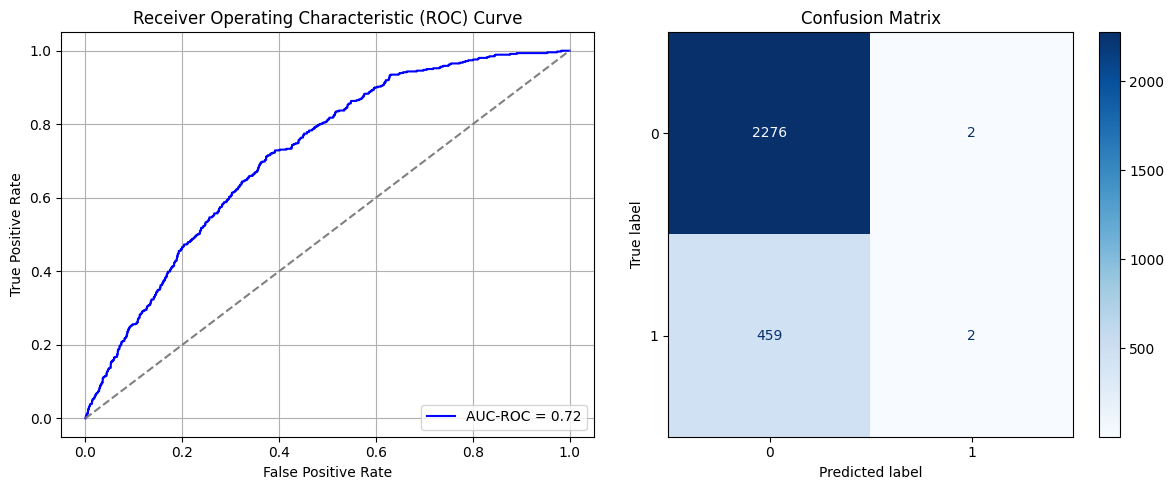

Best threshold based on F1-score: 0.19929233193397522
Time elapsed (performance): 11.034988483999769


In [309]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_437 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_438 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_439 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_440 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_441 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_442 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_443 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7207 - loss: 0.7014 - val_AUC: 0.0000e+00 - val_loss: 0.6728
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7152 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_loss: 0.7632
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7143 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.8058
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.7916
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7220 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8045
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7385 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7137 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.7943
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7279 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.8137
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

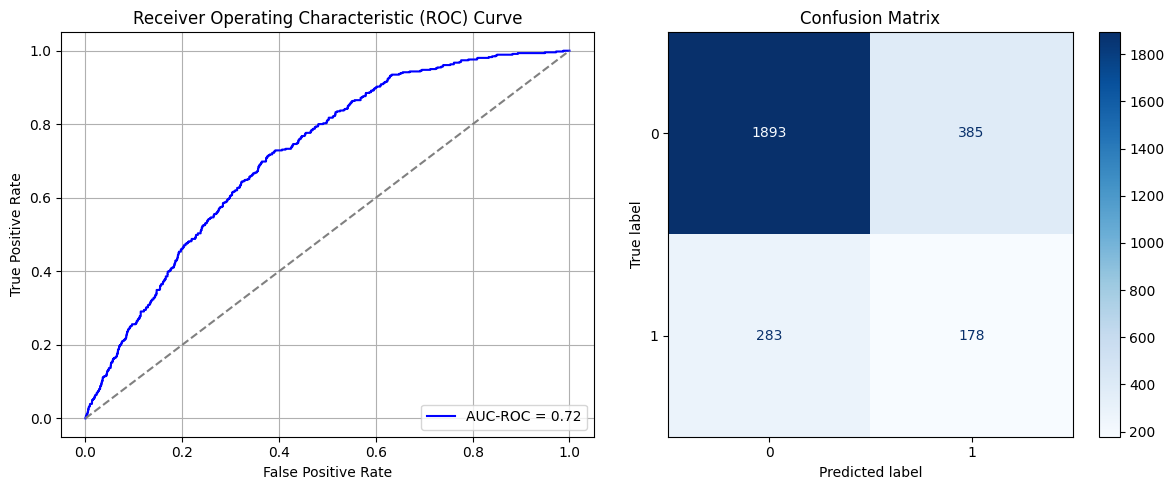

Best threshold based on F1-score: 0.38573431968688965
Time elapsed (performance): 7.339881319001506


In [310]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 5)

## Simple Random Sampling with Replacement:

In [312]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRSwR)

31820
208165
19873     0
34215     0
22174     0
234103    0
145395    0
         ..
253630    1
253636    1
253659    1
253670    1
253679    1
Name: Diabetes_binary, Length: 63640, dtype: int64


In [313]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train[6])
print(y_T_train_SRSwR)

1964
8992
53070     0.0
156329    0.0
29986     0.0
244955    0.0
248787    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3928, dtype: float64


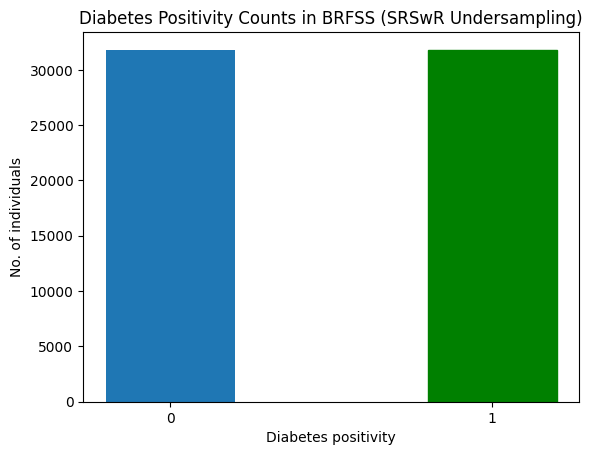

In [314]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [315]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [316]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_444 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_445 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_446 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_447 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_448 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_449 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_450 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.7774 - loss: 0.5628 - val_AUC: 0.8164 - val_loss: 0.5199
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8177 - loss: 0.5173 - val_AUC: 0.8194 - val_loss: 0.5181
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8214 - loss: 0.5119 - val_AUC: 0.8205 - val_loss: 0.5208
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8175 - loss: 0.5163 - val_AUC: 0.8202 - val_loss: 0.5160
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8237 - loss: 0.5104 - val_AUC: 0.8218 - val_loss: 0.5158
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8269 - loss: 0.5046 - val_AUC: 0.8210 - val_loss: 0.5199
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8274 - loss: 0.5048 - val_AUC: 0.8224 - val_loss: 0.5218
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8272 - loss: 0.5047 - val_AUC: 0.8230 - val_loss: 0.5192
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━

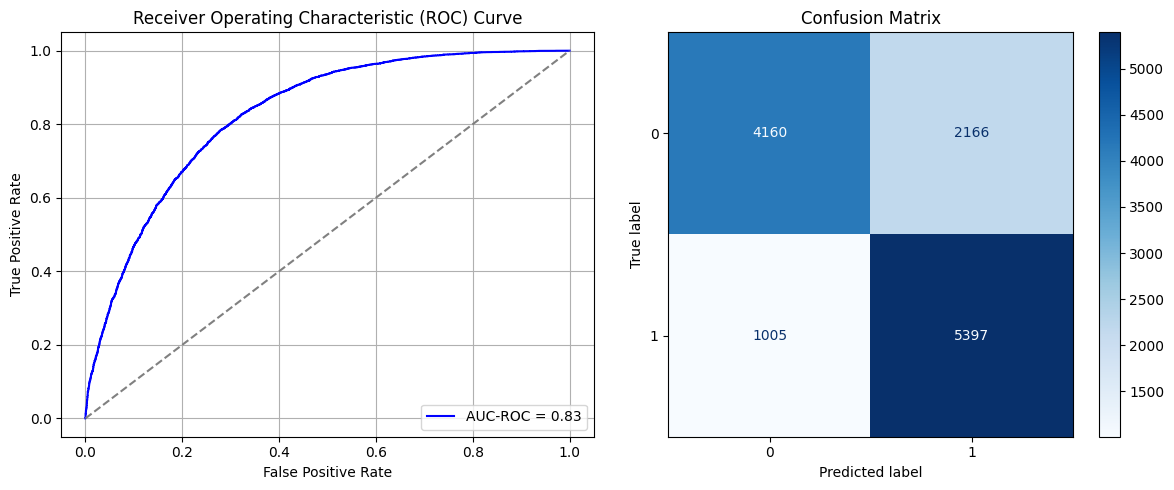

<ipython-input-250-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9789159893989563
Time elapsed (performance): 75.5638659870001


<Sequential name=sequential_74, built=True>

In [317]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7051067553644309
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.37      0.54      2278
         1.0       0.23      0.90      0.36       461

    accuracy                           0.46      2739
   macro avg       0.59      0.64      0.45      2739
weighted avg       0.83      0.46      0.51      2739

FPR 0.6259877085162423 TPR: 0.8980477223427332 FNR: 0.1019522776572668 TNR: 0.3740122914837577


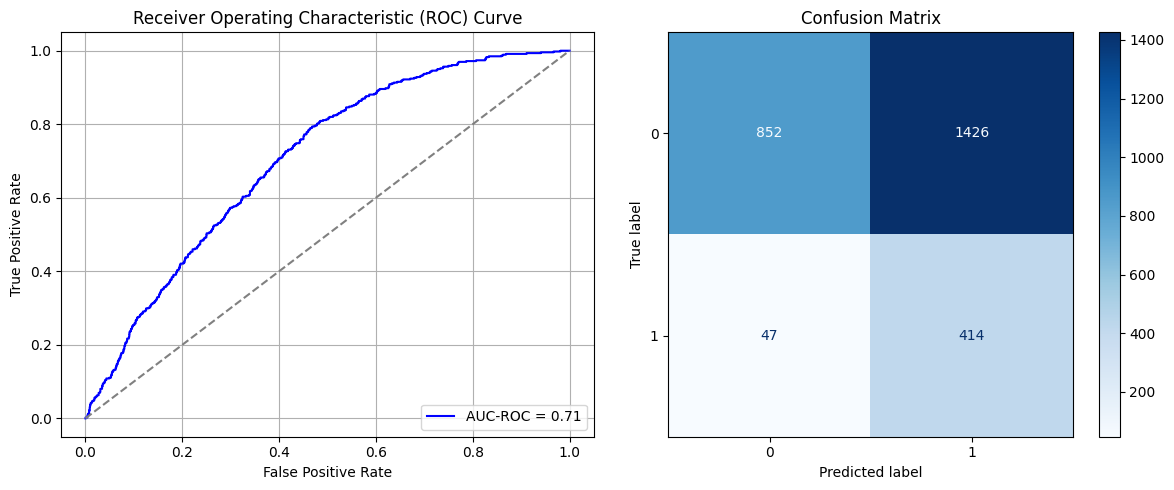

Best threshold based on F1-score: 0.6460587978363037
False Negative Rate: 0.1019522776572668
Time elapsed (performance): 1.9564337729989347


In [318]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_451 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_452 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_453 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_454 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_455 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_456 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_457 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6637 - loss: 0.6332 - val_AUC: 0.6723 - val_loss: 0.4548
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7072 - loss: 0.4317 - val_AUC: 0.6771 - val_loss: 0.4500
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7083 - loss: 0.4146 - val_AUC: 0.6783 - val_loss: 0.4482
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7107 - loss: 0.4287 - val_AUC: 0.6796 - val_loss: 0.4484
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6992 - loss: 0.4271 - val_AUC: 0.6799 - val_loss: 0.4476
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7018 - loss: 0.4277 - val_AUC: 0.6799 - val_loss: 0.4472
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6980 - loss: 0.4242 - val_AUC: 0.6805 - val_loss: 0.4475
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7063 - loss: 0.4226 - val_AUC: 0.6811 - val_loss: 0.4472
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7035 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


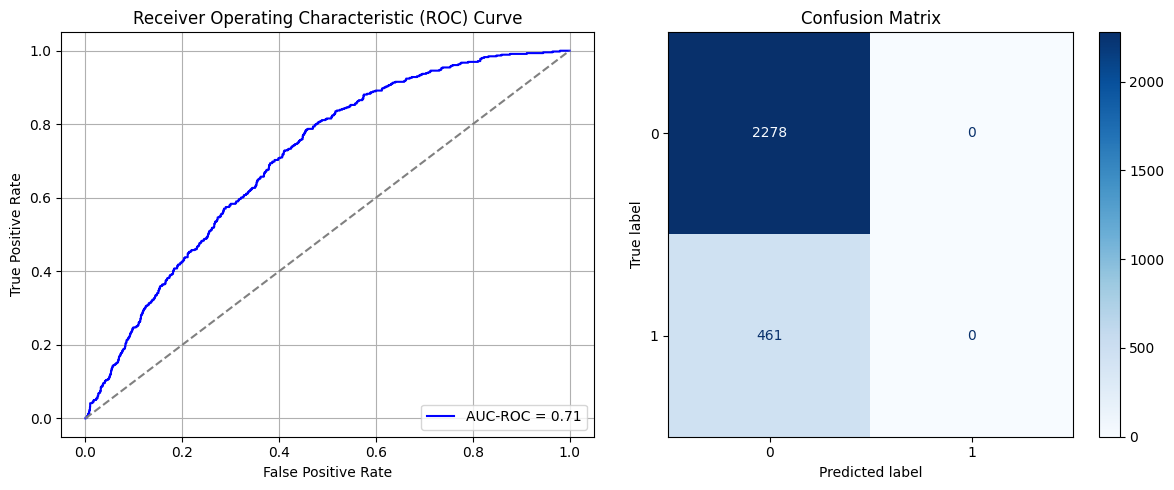

Best threshold based on F1-score: 0.15971939265727997
Time elapsed (performance): 12.14885563399912


In [319]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_479 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_480 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_481 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_482 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_483 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_484 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_485 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.7030 - loss: 0.6947 - val_AUC: 0.0000e+00 - val_loss: 0.7987
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6984 - loss: 0.6013 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6980 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.8656
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6986 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8238
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6838 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_loss: 0.8326
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6942 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8099
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7068 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8579
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7003 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0

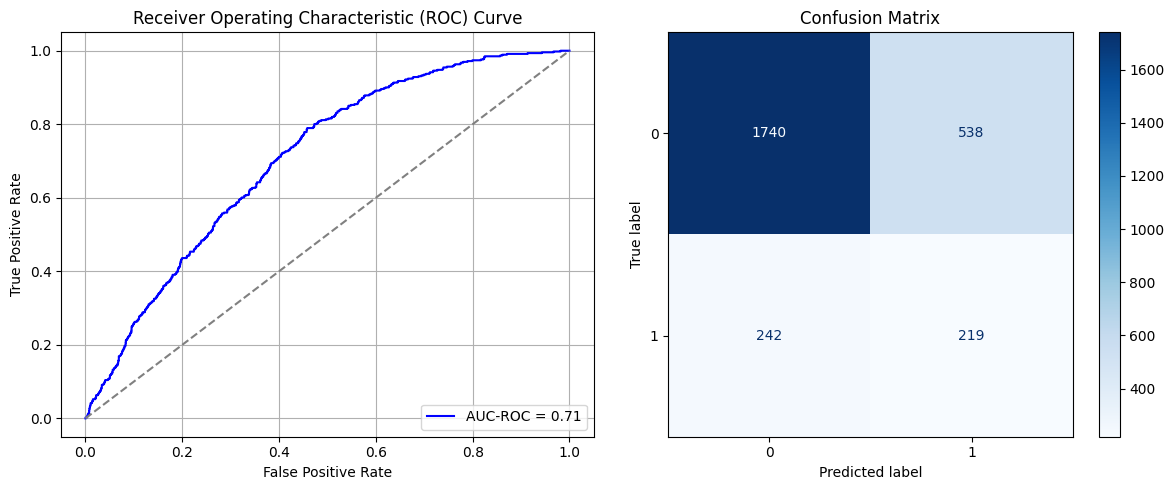

Best threshold based on F1-score: 0.3803001940250397
Time elapsed (performance): 13.6662966519998


In [323]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 5)

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [328]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train[6])
print(y_T_train_Sy)


31820
208165
6.5419547454431175
1
[0, 6, 13, 19, 26, 32, 39, 45, 52, 58, 65, 71, 78, 85, 91, 98, 104, 111, 117, 124, 130, 137, 143, 150, 157, 163, 170, 176, 183, 189, 196, 202, 209, 215, 222, 228, 235, 242, 248, 255, 261, 268, 274, 281, 287, 294, 300, 307, 314, 320, 327, 333, 340, 346, 353, 359, 366, 372, 379, 385, 392, 399, 405, 412, 418, 425, 431, 438, 444, 451, 457, 464, 471, 477, 484, 490, 497, 503, 510, 516, 523, 529, 536, 542, 549, 556, 562, 569, 575, 582, 588, 595, 601, 608, 614, 621, 628, 634, 641, 647, 654, 660, 667, 673, 680, 686, 693, 699, 706, 713, 719, 726, 732, 739, 745, 752, 758, 765, 771, 778, 785, 791, 798, 804, 811, 817, 824, 830, 837, 843, 850, 856, 863, 870, 876, 883, 889, 896, 902, 909, 915, 922, 928, 935, 942, 948, 955, 961, 968, 974, 981, 987, 994, 1000, 1007, 1014, 1020, 1027, 1033, 1040, 1046, 1053, 1059, 1066, 1072, 1079, 1085, 1092, 1099, 1105, 1112, 1118, 1125, 1131, 1138, 1144, 1151, 1157, 1164, 1171, 1177, 1184, 1190, 1197, 1203, 1210, 1216, 1223, 1229, 12

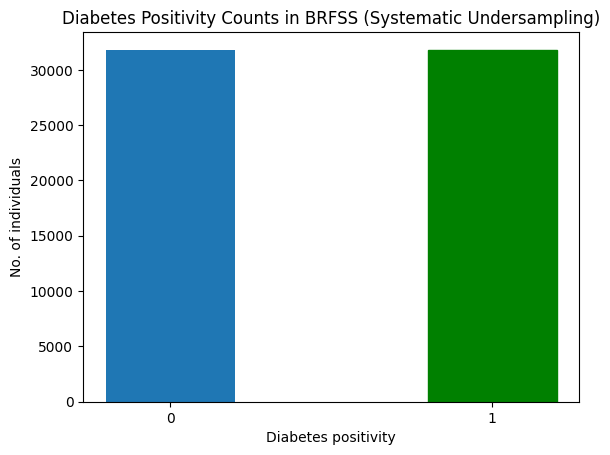

In [329]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [330]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [331]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_486 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_487 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_488 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_489 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_490 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_491 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_492 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7759 - loss: 0.5637 - val_AUC: 0.8201 - val_loss: 0.5199
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8080 - loss: 0.5272 - val_AUC: 0.8228 - val_loss: 0.5127
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8156 - loss: 0.5189 - val_AUC: 0.8243 - val_loss: 0.5219
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8214 - loss: 0.5126 - val_AUC: 0.8226 - val_loss: 0.5184
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - AUC: 0.8215 - loss: 0.5124 - val_AUC: 0.8237 - val_loss: 0.5127
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.8227 - loss: 0.5096 - val_AUC: 0.8254 - val_loss: 0.5123
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.8231 - loss: 0.5093 - val_AUC: 0.8264 - val_loss: 0.5111
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8277 - loss: 0.5049 - val_AUC: 0.8264 - val_loss: 0.5112
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━

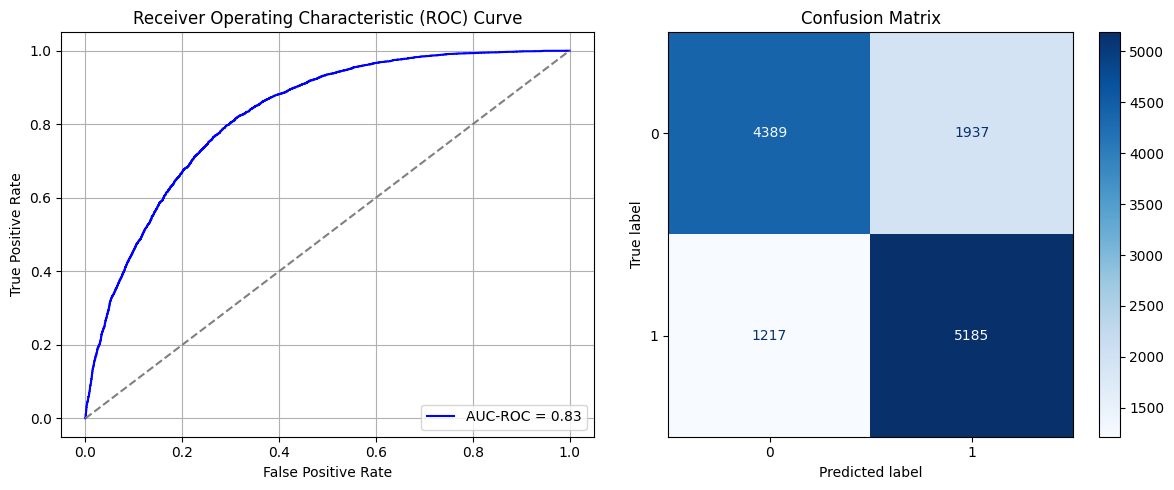

<ipython-input-250-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9735767841339111
Time elapsed (performance): 63.64762236599927


<Sequential name=sequential_80, built=True>

In [332]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.7127877130233538
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.36      0.52     11270
         1.0       0.24      0.92      0.38      2425

    accuracy                           0.46     13695
   macro avg       0.60      0.64      0.45     13695
weighted avg       0.83      0.46      0.50     13695

FPR 0.6394853593611357 TPR: 0.9191752577319587 FNR: 0.08082474226804123 TNR: 0.3605146406388643


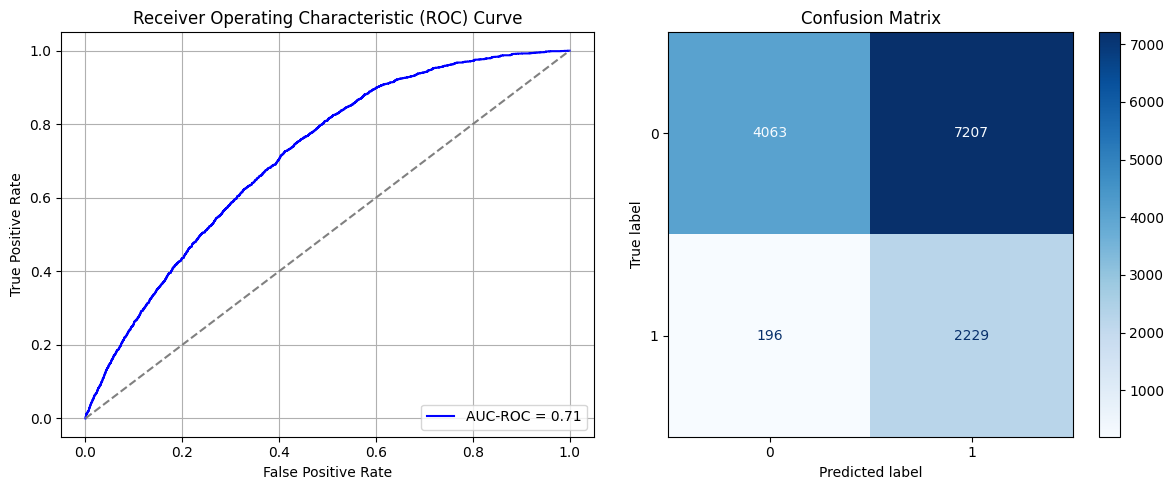

Best threshold based on F1-score: 0.6848985552787781
False Negative Rate: 0.08082474226804123
Time elapsed (performance): 1.4014408370003366


In [333]:
Transductive_TL(model_source_Sy, data_T_X, data_T_y, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_493 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_494 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_495 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_496 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_497 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_498 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_499 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6459 - loss: 0.6224 - val_AUC: 0.6586 - val_loss: 0.4564
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6944 - loss: 0.4382 - val_AUC: 0.6940 - val_loss: 0.4468
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7139 - loss: 0.4274 - val_AUC: 0.6957 - val_loss: 0.4432
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7141 - loss: 0.4245 - val_AUC: 0.6960 - val_loss: 0.4421
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7162 - loss: 0.4228 - val_AUC: 0.6965 - val_loss: 0.4421
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7169 - loss: 0.4235 - val_AUC: 0.6974 - val_loss: 0.4417
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7273 - loss: 0.4135 - val_AUC: 0.6978 - val_loss: 0.4413
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7163 - loss: 0.4214 -

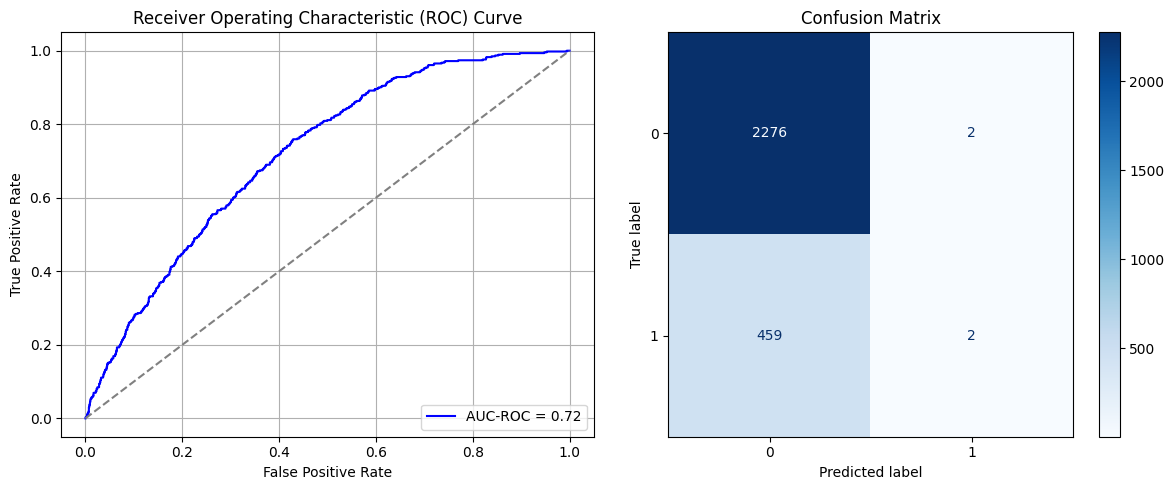

Best threshold based on F1-score: 0.18903177976608276
Time elapsed (performance): 10.65907519799839


In [334]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_501 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_502 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_503 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_504 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_505 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_506 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6931 - loss: 0.6972 - val_AUC: 0.0000e+00 - val_loss: 0.7775
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7287 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.8488
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6999 - loss: 0.6052 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7150 - loss: 0.5881 - val_AUC: 0.0000e+00 - val_loss: 0.8411
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7218 - loss: 0.5870 - val_AUC: 0.0000e+00 - val_loss: 0.8501
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7274 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.8743
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7122 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7280 - loss: 0.5841 - val_AUC: 0.0000e+00 - val_loss: 0.9010
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

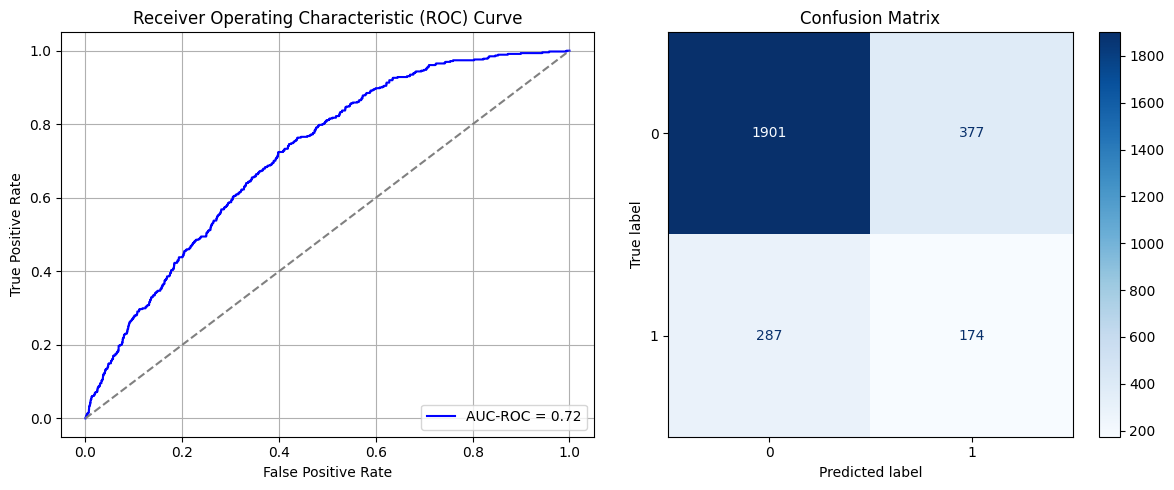

Best threshold based on F1-score: 0.38667988777160645
Time elapsed (performance): 6.185763860999941


In [335]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 5)

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [354]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full['Diabetes_binary'], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train[6], 10)
print(y_T_train_Sy)

31820
208165
6.5419547454431175
[47, 53, 60, 66, 73, 79, 86, 92, 99, 105, 112, 118, 125, 132, 138, 145, 151, 158, 164, 171, 177, 184, 190, 197, 204, 210, 217, 223, 230, 236, 243, 249, 256, 262, 269, 275, 282, 289, 295, 302, 308, 315, 321, 328, 334, 341, 347, 354, 361, 367, 374, 380, 387, 393, 400, 406, 413, 419, 426, 432, 439, 446, 452, 459, 465, 472, 478, 485, 491, 498, 504, 511, 518, 524, 531, 537, 544, 550, 557, 563, 570, 576, 583, 589, 596, 603, 609, 616, 622, 629, 635, 642, 648, 655, 661, 668, 675, 681, 688, 694, 701, 707, 714, 720, 727, 733, 740, 746, 753, 760, 766, 773, 779, 786, 792, 799, 805, 812, 818, 825, 832, 838, 845, 851, 858, 864, 871, 877, 884, 890, 897, 903, 910, 917, 923, 930, 936, 943, 949, 956, 962, 969, 975, 982, 989, 995, 1002, 1008, 1015, 1021, 1028, 1034, 1041, 1047, 1054, 1061, 1067, 1074, 1080, 1087, 1093, 1100, 1106, 1113, 1119, 1126, 1132, 1139, 1146, 1152, 1159, 1165, 1172, 1178, 1185, 1191, 1198, 1204, 1211, 1218, 1224, 1231, 1237, 1244, 1250, 1257, 1263, 

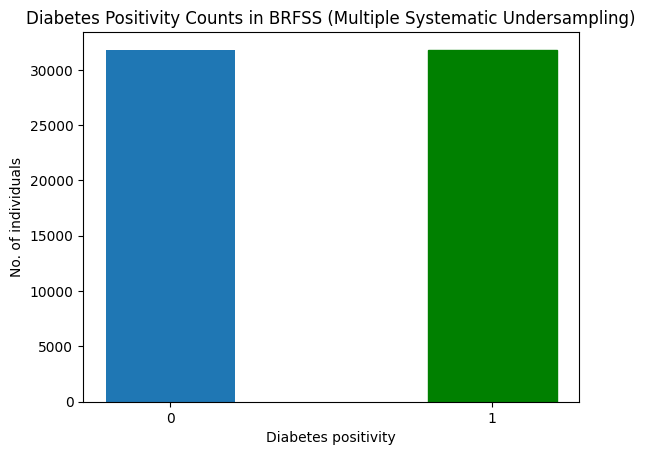

In [355]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [356]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [357]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_507 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_510 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_511 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_513 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7922 - loss: 0.5478 - val_AUC: 0.8277 - val_loss: 0.5191
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8252 - loss: 0.5072 - val_AUC: 0.8343 - val_loss: 0.5022
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8277 - loss: 0.5043 - val_AUC: 0.8362 - val_loss: 0.5093
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - AUC: 0.8328 - loss: 0.4971 - val_AUC: 0.8367 - val_loss: 0.4978
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8345 - loss: 0.4966 - val_AUC: 0.8362 - val_loss: 0.5056
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8332 - loss: 0.4969 - val_AUC: 0.8390 - val_loss: 0.4953
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8395 - loss: 0.4890 - val_AUC: 0.8391 - val_loss: 0.4930
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8400 - loss: 0.4885 - val_AUC: 0.8387 - val_loss: 0.5010
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━

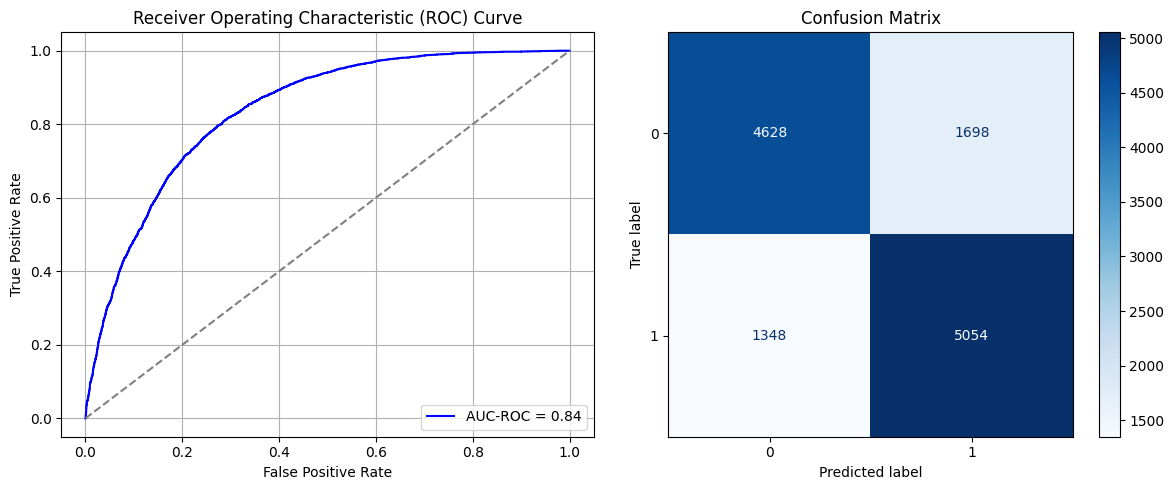

Best threshold based on F1-score: 0.38225966691970825
Time elapsed (performance): 59.6211214820014


<Sequential name=sequential_83, built=True>

In [358]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC-ROC: 0.7192254228450681
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.37      0.53     11270
         1.0       0.24      0.92      0.38      2425

    accuracy                           0.47     13695
   macro avg       0.60      0.64      0.45     13695
weighted avg       0.83      0.47      0.50     13695

FPR 0.6330967169476486 TPR: 0.9220618556701031 FNR: 0.0779381443298969 TNR: 0.3669032830523514


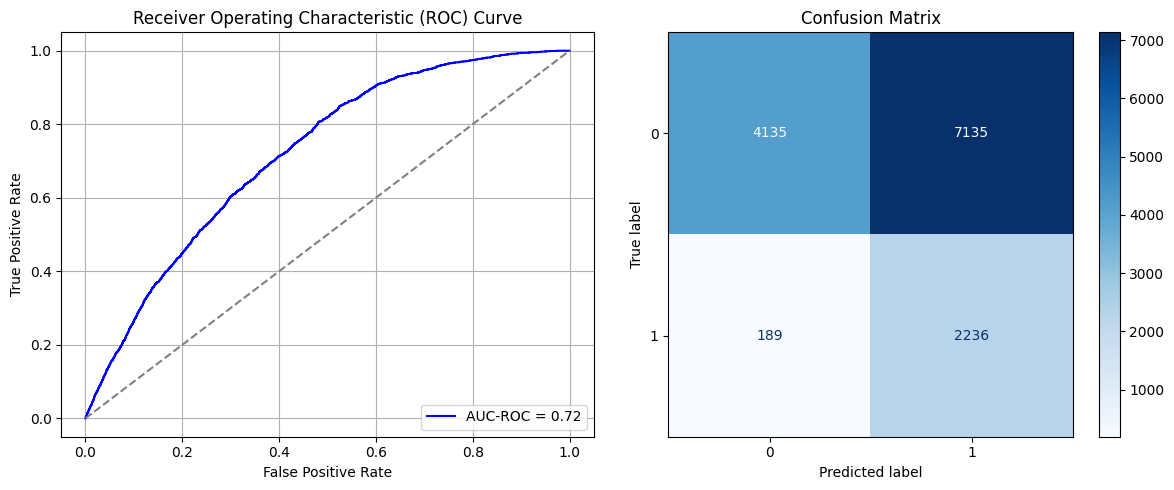

Best threshold based on F1-score: 0.7783124446868896
False Negative Rate: 0.0779381443298969
Time elapsed (performance): 2.2238279089997377


In [359]:
Transductive_TL(model_source_Sy, data_T_X, data_T_y, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_514 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_515 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_516 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_517 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_518 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_519 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_520 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6663 - loss: 0.6596 - val_AUC: 0.6902 - val_loss: 0.4565
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7043 - loss: 0.4383 - val_AUC: 0.6982 - val_loss: 0.4465
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7219 - loss: 0.4141 - val_AUC: 0.6996 - val_loss: 0.4419
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7113 - loss: 0.4223 - val_AUC: 0.7001 - val_loss: 0.4413
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7225 - loss: 0.4247 - val_AUC: 0.7008 - val_loss: 0.4406
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7182 - loss: 0.4182 - val_AUC: 0.7013 - val_loss: 0.4433
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7205 - loss: 0.4246 - val_AUC: 0.7021 - val_loss: 0.4404
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7255 - loss: 0.4155 - val_AUC: 0.7023 - val_loss: 0.4408
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7122 -

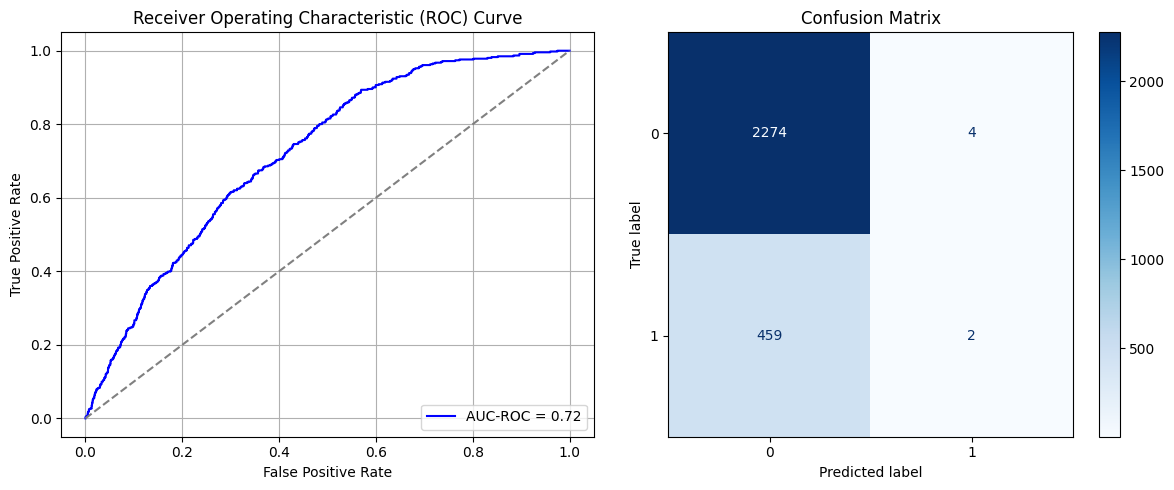

Best threshold based on F1-score: 0.2264198511838913
Time elapsed (performance): 11.30739625699971


In [360]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_521 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_522 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_523 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_524 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_525 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_526 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_527 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.7233 - loss: 0.7144 - val_AUC: 0.0000e+00 - val_loss: 0.7096
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7270 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.7908
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7170 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7163 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8250
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7254 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.7993
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7077 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.7843
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6973 - loss: 0.5920 - val_AUC: 0.0000e+00 - val_loss: 0.7881
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6932 - loss: 0.5940 - val_AUC: 0.0000e+00 - val_loss: 0.7933
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

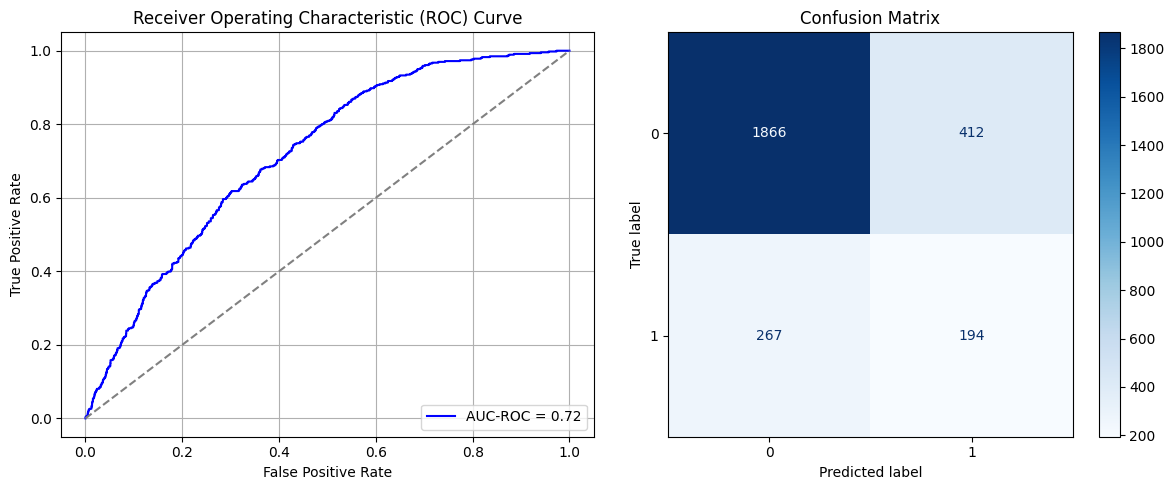

Best threshold based on F1-score: 0.4470978379249573
Time elapsed (performance): 6.829742451000129


In [361]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 5)

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [367]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train[6])
print(y_T_train_Sy)

31820
208165
0         0
1         0
2         0
4         0
5         0
         ..
41447     1
20037     1
174108    1
225124    1
153448    1
Name: Diabetes_binary, Length: 416330, dtype: int64
1964
8992
41653     0.0
159829    0.0
172532    0.0
11772     0.0
239379    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3924, dtype: float64


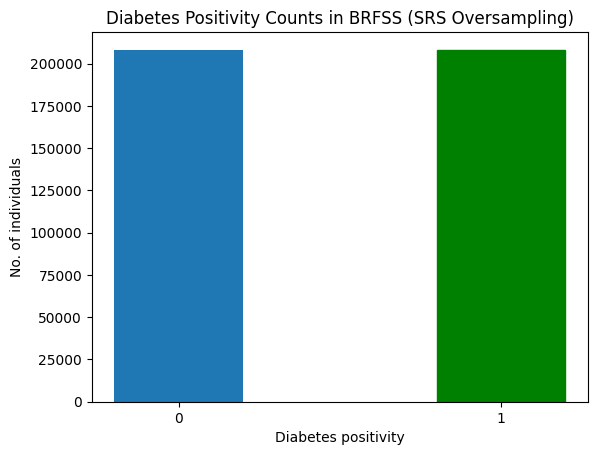

In [368]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [369]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_528 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_529 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_530 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_531 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_532 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_533 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_534 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - AUC: 0.7881 - loss: 0.5524 - val_AUC: 0.8298 - val_loss: 0.5114
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8251 - loss: 0.5079 - val_AUC: 0.8335 - val_loss: 0.5026
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.8353 - loss: 0.4946 - val_AUC: 0.8364 - val_loss: 0.5084
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8360 - loss: 0.4947 - val_AUC: 0.8371 - val_loss: 0.4969
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - AUC: 0.8348 - loss: 0.4955 - val_AUC: 0.8362 - val_loss: 0.5034
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8359 - loss: 0.4945 - val_AUC: 0.8374 - val_loss: 0.5015
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8416 - loss: 0.4867 - val_AUC: 0.8395 - val_loss: 0.4950
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8389 - loss: 0.4903 - val_AUC: 0.8402 - val_loss: 0.4921
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━

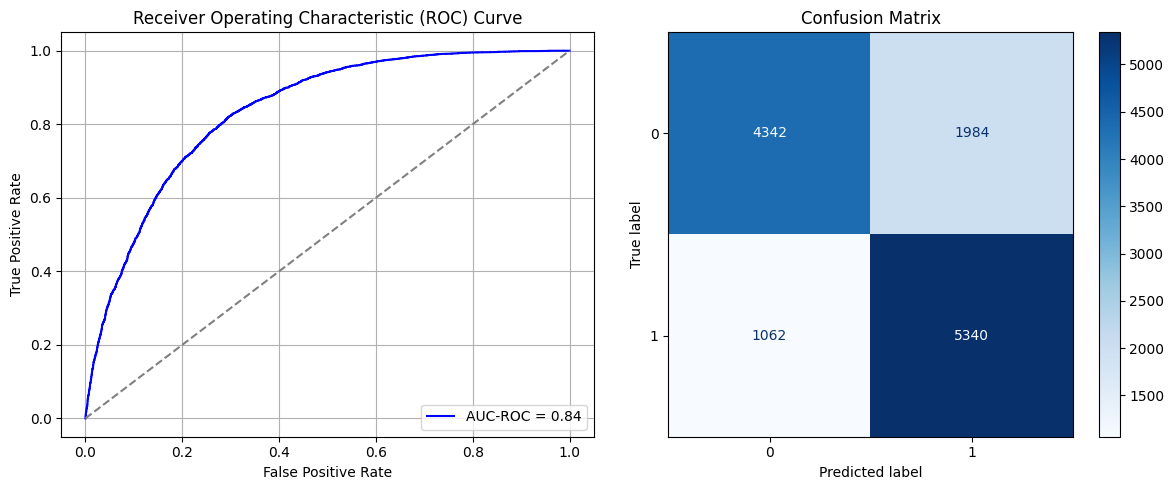

Best threshold based on F1-score: 0.4630843698978424
Time elapsed (performance): 66.65221762299916


<Sequential name=sequential_86, built=True>

In [370]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC-ROC: 0.7037600051226228
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.35      0.51     11270
         1.0       0.23      0.90      0.37      2425

    accuracy                           0.44     13695
   macro avg       0.59      0.63      0.44     13695
weighted avg       0.82      0.44      0.48     13695

FPR 0.6539485359361136 TPR: 0.9043298969072164 FNR: 0.09567010309278351 TNR: 0.3460514640638864


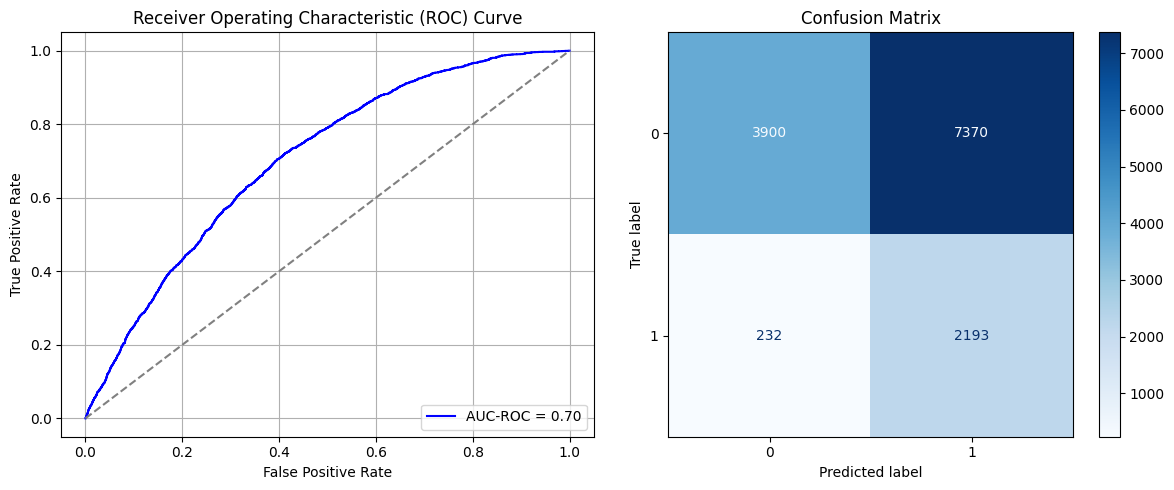

Best threshold based on F1-score: 0.7297859787940979
False Negative Rate: 0.09567010309278351
Time elapsed (performance): 3.046642219000205


In [371]:
Transductive_TL(model_source_SRS_ROS, data_T_X, data_T_y, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_535 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_536 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_537 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_538 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_539 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_540 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_541 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6491 - loss: 0.6588 - val_AUC: 0.6847 - val_loss: 0.4649
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7035 - loss: 0.4295 - val_AUC: 0.6864 - val_loss: 0.4580
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7052 - loss: 0.4303 - val_AUC: 0.6870 - val_loss: 0.4512
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7122 - loss: 0.4274 - val_AUC: 0.6872 - val_loss: 0.4505
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7070 - loss: 0.4242 - val_AUC: 0.6884 - val_loss: 0.4503
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7126 - loss: 0.4224 - val_AUC: 0.6891 - val_loss: 0.4489
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7120 - loss: 0.4309 - val_AUC: 0.6898 - val_loss: 0.4482
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7087 - loss: 0.4203 - val_AUC: 0.6902 - val_loss: 0.4493
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7064 -

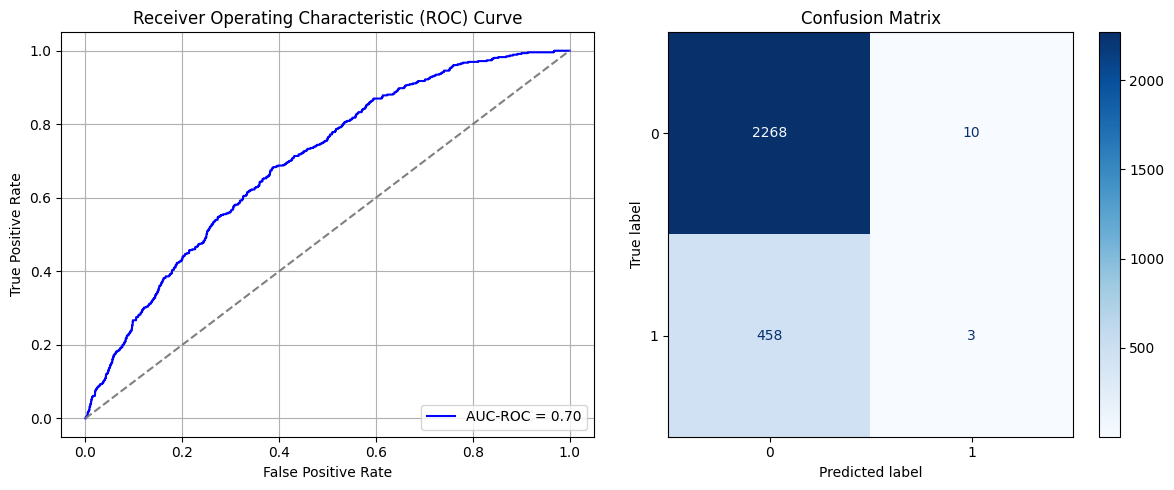

Best threshold based on F1-score: 0.17784108221530914
Time elapsed (performance): 11.998775141000806


In [372]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_542 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_543 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_544 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_545 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_546 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_547 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_548 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6938 - loss: 0.6468 - val_AUC: 0.0000e+00 - val_loss: 0.8721
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7053 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.8652
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7018 - loss: 0.5963 - val_AUC: 0.0000e+00 - val_loss: 0.9155
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7045 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7089 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8657
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7071 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.8399
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7127 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.8989
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - 

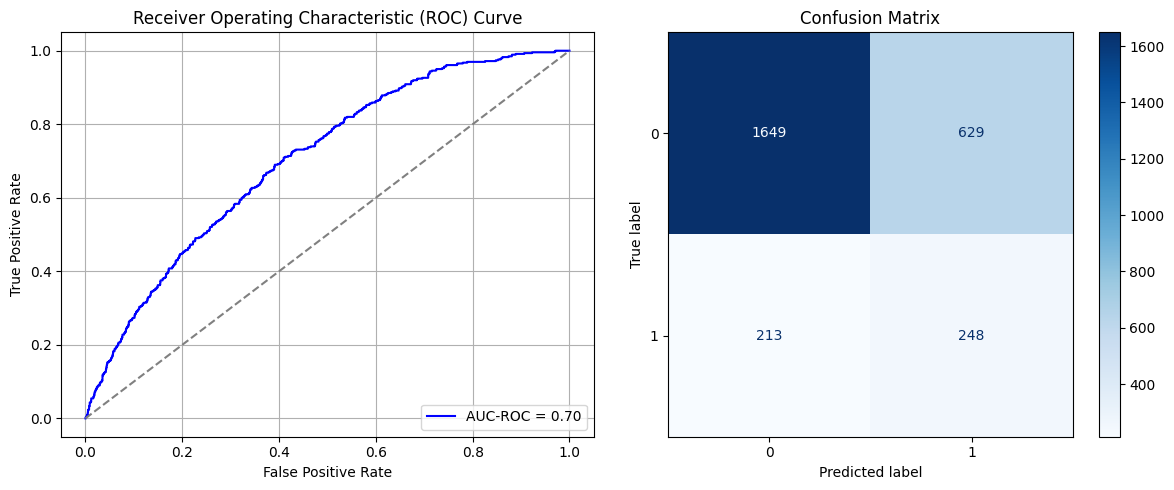

Best threshold based on F1-score: 0.4241328239440918
Time elapsed (performance): 18.720749088999582


In [373]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 5)

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=266.01 \approx 266$, so we take $k=48$ for the source data resampling. Similarly, we take $k=50$ for the target training data resampling, as this yields a $k*\frac{N_0-N_1}{N_1}=178.92 \approx 179$.

In [385]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full['Diabetes_binary'], 48)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train[6], 50)
print(y_T_train_Sy)

31820
208165
Nsamples= 266.01382778126964
0         0
1         0
2         0
4         0
5         0
         ..
251761    1
252023    1
252421    1
252732    1
253055    1
Name: Diabetes_binary, Length: 416077, dtype: int64
1964
8992
Nsamples= 178.9205702647658
126273    0.0
191397    0.0
158309    0.0
83510     0.0
194674    0.0
         ... 
136684    1.0
59235     1.0
84125     1.0
180511    1.0
78825     1.0
Name: 6, Length: 17898, dtype: float64


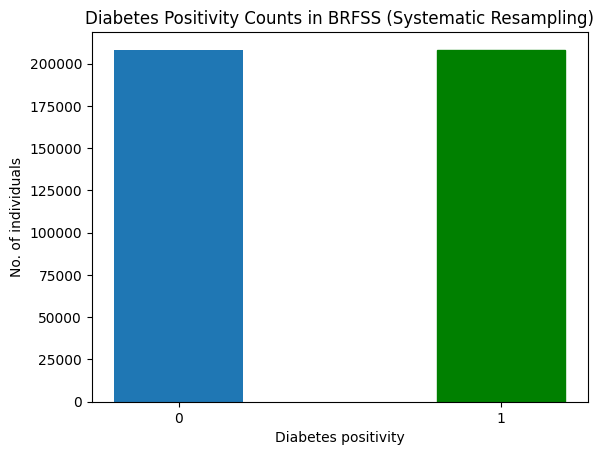

In [386]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [397]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_598 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_599 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_600 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_601 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_602 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_603 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_604 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8082 - loss: 0.5281 - val_AUC: 0.8256 - val_loss: 0.5070
Epoch 2/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8279 - loss: 0.5043 - val_AUC: 0.8278 - val_loss: 0.5070
Epoch 3/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8299 - loss: 0.5023 - val_AUC: 0.8294 - val_loss: 0.5025
Epoch 4/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8314 - loss: 0.4995 - val_AUC: 0.8297 - val_loss: 0.5023
Epoch 5/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8306 - loss: 0.5002 - val_AUC: 0.8299 - val_loss: 0.5065
Epoch 6/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - AUC: 0.8322 - loss: 0.4979 - val_AUC: 0.8299 - val_loss: 0.5020
Epoch 7/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8344 - loss: 0.4951 - val_AUC: 0.8316 - val_loss: 0.4985
Epoch 8/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8349 - loss: 0.4945 - val_AUC: 0.8313 - val_loss: 0.5065
Epoch 9/10
8322/8322 ━━━━━━━━━━━

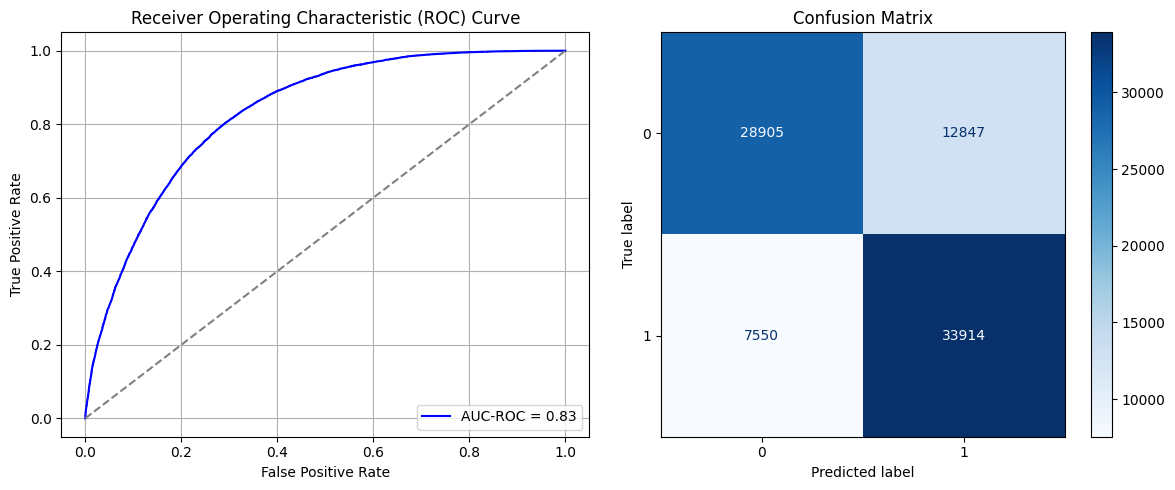

Best threshold based on F1-score: 0.40185675024986267
Time elapsed (performance): 326.6918038519998


<Sequential name=sequential_96, built=True>

In [398]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

428/428 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.6953654168076913
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.39      0.55     11270
         1.0       0.24      0.88      0.37      2425

    accuracy                           0.48     13695
   macro avg       0.59      0.64      0.46     13695
weighted avg       0.81      0.48      0.52     13695

FPR 0.6090505767524401 TPR: 0.8820618556701031 FNR: 0.11793814432989691 TNR: 0.3909494232475599


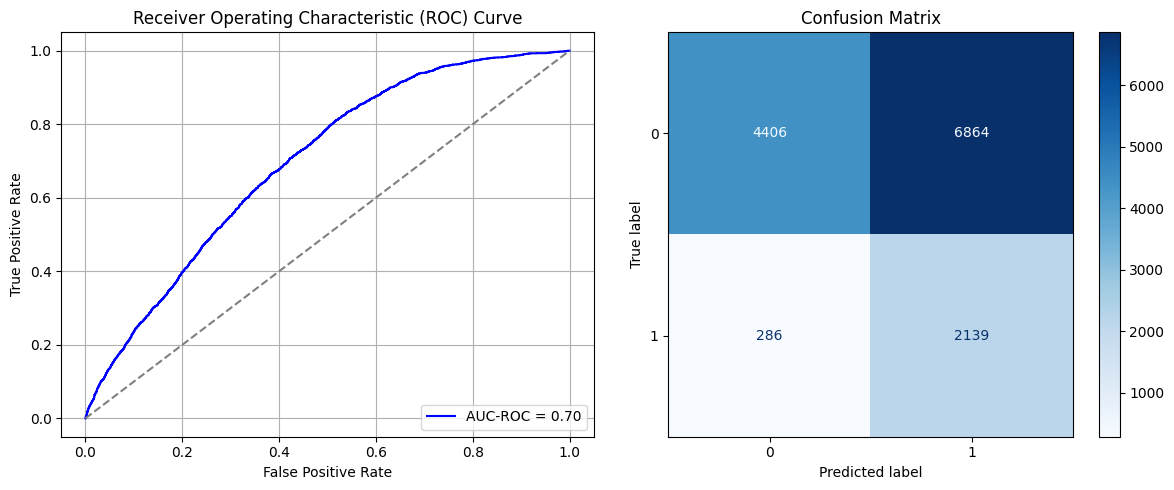

Best threshold based on F1-score: 0.7007220387458801
False Negative Rate: 0.11793814432989691
Time elapsed (performance): 1.3799965719990723


In [399]:
Transductive_TL(model_source_Sy_ROS, data_T_X, data_T_y, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_605 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_606 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_607 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_608 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_609 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_610 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_611 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6764 - loss: 0.7116 - val_AUC: 0.5843 - val_loss: 0.4772
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.5937 - loss: 0.4727 - val_AUC: 0.6710 - val_loss: 0.4599
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6825 - loss: 0.4383 - val_AUC: 0.6805 - val_loss: 0.4527
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6970 - loss: 0.4349 - val_AUC: 0.6816 - val_loss: 0.4497
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7033 - loss: 0.4357 - val_AUC: 0.6818 - val_loss: 0.4475
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6976 - loss: 0.4285 - val_AUC: 0.6826 - val_loss: 0.4465
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6900 - loss: 0.4292 - val_AUC: 0.6829 - val_loss: 0.4459
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7186 - loss: 0.4131 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


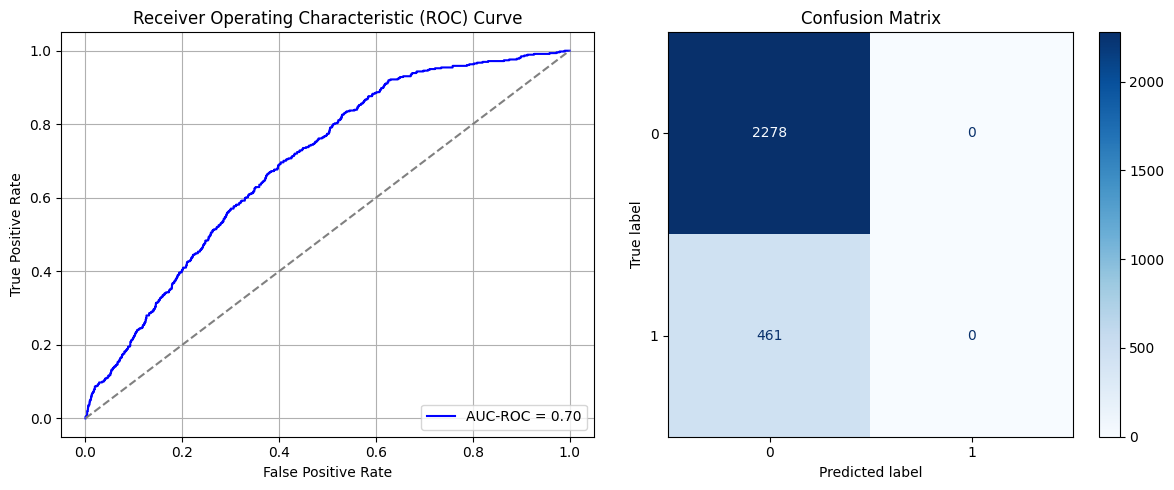

Best threshold based on F1-score: 0.20798949897289276
Time elapsed (performance): 11.903033292001055


In [400]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_633 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_634 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_635 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_636 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_637 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_638 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_639 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6836 - loss: 0.6741 - val_AUC: 0.0000e+00 - val_loss: 0.8148
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6995 - loss: 0.6031 - val_AUC: 0.0000e+00 - val_loss: 0.8717
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6891 - loss: 0.6064 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6970 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8873
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7013 - loss: 0.5907 - val_AUC: 0.0000e+00 - val_loss: 0.8092
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6925 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.8849
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6995 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6986 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.8416
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

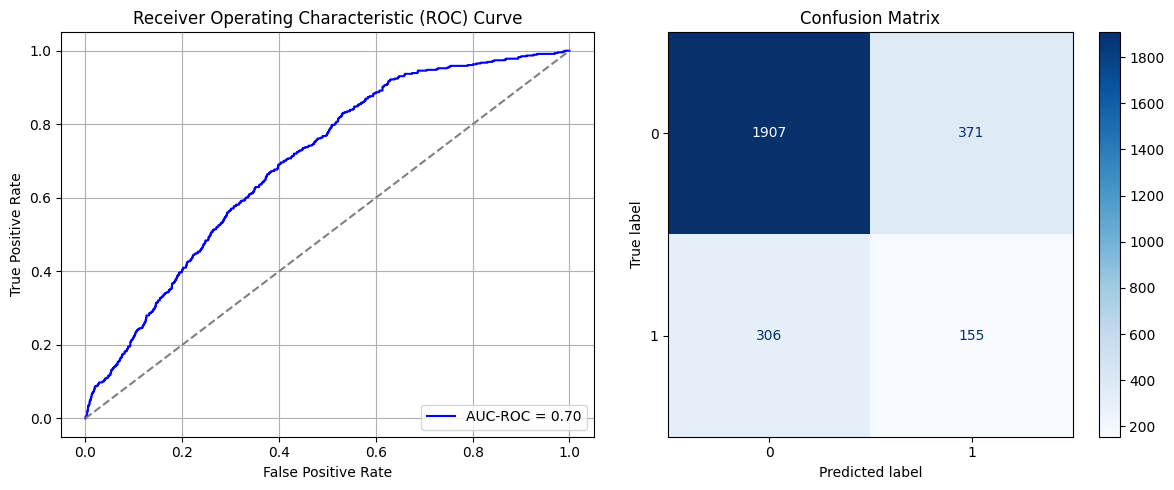

Best threshold based on F1-score: 0.42141103744506836
Time elapsed (performance): 15.42838365300122


In [404]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 5)